# Overview

Kaggle's Titanic ML Challenge: Predict survival based on passenger's information. 
Below is my solution, with the help of tutorials from [here](https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html) and [here](https://github.com/ramansah/kaggle-titanic/blob/master/Analysis.ipynb)

# Strategy

Data Massaging:
- Import data and determine features that have missing values (for imputation), Nominal variables (for one hot encoding), continuous variables (for feature scaling)
- Transform string variables into numerical values, or one-hot encode them

Modeling:
- Scale continuous features before moeling. 
- Try random forests and XGBoost

Best practices I have discovered:

- During data transformation/imputation, test set must be transformed/imputed based on training set
- Imputation practices:
    - impute values that are from training set's distribution
    - impute values in dataframe: use df.loc[index, column], for example:
    
    `dataset.loc[dataset.Age.isnull() & (dataset['Title'] == title), 'Age'] = group_median`
    
- Create another dataset after dropping variables


# Import packages

In [111]:
# data analysis
import pandas as pd 
import numpy as np
from collections import Counter

# visualisation
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(9,6)})

# machine learning 
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron 
from sklearn.linear_model import SGDClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Import data

In [112]:
train_csv = "/Users/rouenlee/github/kaggle/titanic_train.csv"
test_csv = "/Users/rouenlee/github/kaggle/titanic_test.csv"

df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(test_csv)

# Data analysis

In [113]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [114]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Training set: age , cabin and embarked missing.

In [115]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Test set: Age, Fare and cabin missing 

### Exploring data

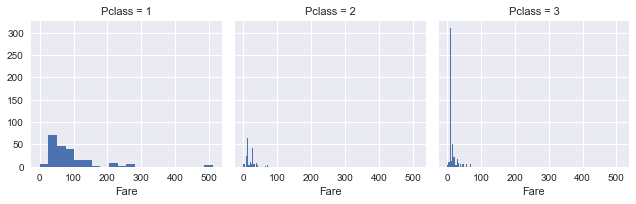

In [116]:
g = sns.FacetGrid(df_train, col = 'Pclass')
g.map(plt.hist,'Fare', bins = 20)

Observation: First class passengers tend to pay higher fare, as expected.

/Users/rouenlee/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


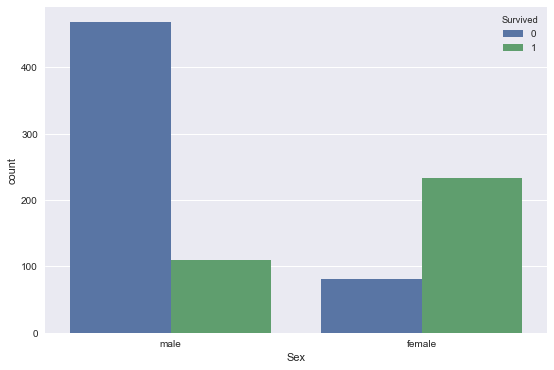

In [117]:
sns.countplot(x = "Sex", hue = "Survived", data = df_train)

Observation: Females have a higher survival rate 

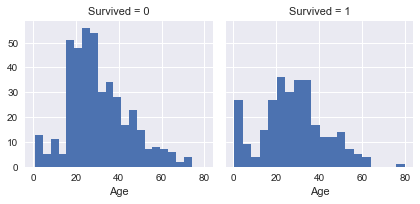

In [118]:
g = sns.FacetGrid(df_train, col = 'Survived')
g.map(plt.hist,'Age', bins = 20)

Infants (below age 10) have a higher survival rate. Among those who did not survive, a considerable proportion is at their late 20s.

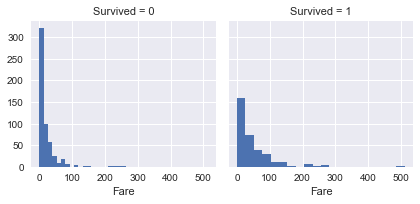

In [119]:
g = sns.FacetGrid(df_train, col = 'Survived')
g.map(plt.hist,'Fare', bins = 20)

# Feature Engineering: FamilySize

In [120]:
combine = [df_train, df_test]
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1


Positive sign: row 329 and 523: same cabin, same fare. 

# Data Preprocessing: Cabin

In [121]:
df_train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

Take the first alphabet of 'Cabin'

In [122]:
combined = [df_train, df_test]

for dataset in combined:
    dataset['CabinLetter'] = dataset.Cabin.str[0]

In [123]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,NaN


/Users/rouenlee/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


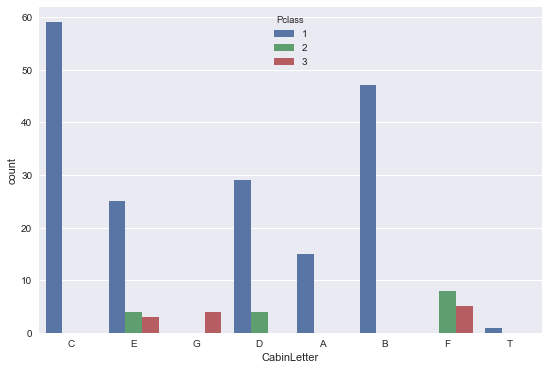

In [124]:
sns.countplot(x = "CabinLetter", hue = "Pclass", data = df_train[df_train['CabinLetter'].notnull()])

Observation: Mostly first class passengers have non-empty cabin info. 

Survival rate of missing cabin:

In [125]:
#Overall survival rate
df_train['Survived'].mean()

0.3838383838383838

In [126]:
# Survival rate of those with non empty cabin info
df_train[df_train['Cabin'].notnull()]['Survived'].mean()

0.6666666666666666

Survival rate nearly doubles is 'cabin' is not empty, therefore, we can try to predict survival based on whether infomation is available for cabin

In [127]:
combined = [df_train, df_test]

for dataset in combined:
    dataset.loc[dataset['CabinLetter'].isnull(),'CabinLetter'] = 'Unknown'

In [128]:
# Check that all 'CabinLetter' has no more missing values
sum(df_train['CabinLetter'].isnull())

0

In [129]:
sum(df_test['CabinLetter'].isnull())

0

# Data Preprocessing: Names 

In [130]:
combine = [df_train, df_test]

In [131]:
# take the word that ends with '.'
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand = False)

pd.crosstab(df_train['Title'],df_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [132]:
set(np.concatenate((df_train['Title'].unique(),df_test['Title'].unique()), axis = 0))

{'Capt',
 'Col',
 'Countess',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir'}

In [133]:
# other_title_map = {
#  'Capt' : 'Officer',
#  'Col' : 'Officer',
#  'Countess': 'Noble',
#  'Don' : 'Noble',
#  'Dona': 'Noble',
#  'Dr' : 'Officer',
#  'Jonkheer' : 'Noble',
#  'Lady': 'Noble',
#  'Major': 'Officer',
#  'Master': 'Master',
#  'Miss': 'Ms',
#  'Mlle' : 'Ms',
#  'Mme': 'Mrs',
#  'Mr' : 'Mr',
#  'Mrs': 'Mrs',
#  'Ms': 'Ms',
#  'Rev' : 'Officer',
#  'Sir' : 'Noble'   
# }

In [134]:
title_map = {
 'Capt' : 'Officer',
 'Col' : 'Officer',
 'Countess': 'Noble',
 'Don' : 'Noble',
 'Dona': 'Noble',
 'Dr' : 'Officer',
 'Jonkheer' : 'Noble',
 'Lady': 'Noble',
 'Major': 'Officer',
 'Master': 'Commoner',
 'Miss': 'Commoner',
 'Mlle' : 'Commoner',
 'Mme': 'Commoner',
 'Mr' : 'Commoner',
 'Mrs': 'Commoner',
 'Ms': 'Commoner',
 'Rev' : 'Officer',
 'Sir' : 'Noble'   
}

According to wikipedia, boys who have not entered society are addressed as [Master]( https://en.wikipedia.org/wiki/Master_(form_of_address). This is verified below:

In [135]:
df_train[df_train['Title'] == 'Master']['Age'].describe()

count    36.000000
mean      4.574167
std       3.619872
min       0.420000
25%       1.000000
50%       3.500000
75%       8.000000
max      12.000000
Name: Age, dtype: float64

In [136]:
for dataset in combine:
    dataset['TitleMap'] = dataset['Title'].map(title_map)

In [137]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter,Title,TitleMap
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Unknown,Mr,Commoner
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,C,Mrs,Commoner
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Unknown,Miss,Commoner


# Impute 'Age' feature

In [138]:
corr = df_train.corr()
corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.040143
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.016639
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.065997
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.301914
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.890712
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.783111
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.217138
FamilySize,-0.040143,0.016639,0.065997,-0.301914,0.890712,0.783111,0.217138,1.000000


Observation: Age has highest correlation with Pclass, SibSp, FamilySize 

In [139]:
# We want to impute age based on Title and Pclass. Check that these features have...
# no missing values
sum(df_train['Title'].isnull()), sum(df_train['Pclass'].isnull()) 

(0, 0)

In [140]:
unique_titles = df_train.append(df_test).Title.unique()
unique_titles

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [141]:
unique_pclass = df_train.append(df_test).Pclass.unique()
unique_pclass

array([3, 1, 2])

Find median age based on training data [only](https://machinelearningmastery.com/data-leakage-machine-learning/), then impute both training and test data. Remember, the goal of predictive modeling is to develop a model that makes accurate predictions on new data, unseen during training.

In [142]:
combine = [df_train,df_test]

for title in unique_titles:
    for pclass in range(1,4):
        guess_df = df_train[(df_train['Title'] == title) & (df_train['Pclass'] == pclass)]['Age'].dropna() 
        group_median = guess_df.median()

        for dataset in combine:
            dataset.loc[(dataset.Age.isnull()) & (dataset.Title == title) & (dataset.Pclass == pclass), 'Age'] = group_median

Note: must group conditions by parentheses, see [here](https://stackoverflow.com/questions/34531416/comparing-dtype-float64-array-with-a-scalar-of-type-bool-in-pandas-dataframe) for more info. 

In [143]:
# Check that all missing values have been imputed 
df_train[df_train['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter,Title,TitleMap


In [144]:
df_test[df_test['Age'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter,Title,TitleMap
88,980,3,"O'Donoghue, Ms. Bridget",female,NaN,0,0,364856,7.75,NaN,Q,1,Unknown,Ms,Commoner


In [145]:
# Because there is no 3rd class Ms in df_train
df_train[(df_train['Title'] == 'Ms') & (df_train['Pclass'] == 3)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter,Title,TitleMap


In [146]:
# Impute based on gender and Pclass 
guess_df = df_train[((df_train['Title'] == 'Ms') | (df_train['Title'] == 'Mlle') | (df_train['Title'] == 'Miss')) & (df_train['Pclass'] == 3)]['Age'].dropna()
median = guess_df.median()
median

18.0

In [147]:
df_test.loc[88,'Age'] = median

In [148]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
FamilySize     418 non-null int64
CabinLetter    418 non-null object
Title          418 non-null object
TitleMap       418 non-null object
dtypes: float64(2), int64(5), object(8)
memory usage: 49.1+ KB


# Impute 'Embarked' feature

In [149]:
ModeEmb = df_train['Embarked'].dropna().mode()[0]

df_train.loc[df_train.Embarked.isnull(), 'Embarked'] = ModeEmb

In [150]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
FamilySize     891 non-null int64
CabinLetter    891 non-null object
Title          891 non-null object
TitleMap       891 non-null object
dtypes: float64(2), int64(6), object(8)
memory usage: 111.5+ KB


# Impute 'Fare' feature 

In [151]:
# there is one missing values for fare:
# find the class of the missing entry
mclass = df_test[df_test['Fare'].isnull()]['Pclass']
mclass

152    3
Name: Pclass, dtype: int64

In [152]:
df_test.loc[152,:]

PassengerId                  1044
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
Age                          60.5
SibSp                           0
Parch                           0
Ticket                       3701
Fare                          NaN
Cabin                         NaN
Embarked                        S
FamilySize                      1
CabinLetter               Unknown
Title                          Mr
TitleMap                 Commoner
Name: 152, dtype: object

In [153]:
# Impute based on Pclass
df_test.loc[152, 'Fare'] = df_train[df_train['Pclass'] == 3]['Fare'].mean()

In [154]:
df_test.loc[152,:]

PassengerId                  1044
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
Age                          60.5
SibSp                           0
Parch                           0
Ticket                       3701
Fare                      13.6756
Cabin                         NaN
Embarked                        S
FamilySize                      1
CabinLetter               Unknown
Title                          Mr
TitleMap                 Commoner
Name: 152, dtype: object

In [155]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
FamilySize     418 non-null int64
CabinLetter    418 non-null object
Title          418 non-null object
TitleMap       418 non-null object
dtypes: float64(2), int64(5), object(8)
memory usage: 49.1+ KB


# One hot encoding for Sex, TitleMap, Embarked, CabinLetter 

In [156]:
Oh_features = ['Sex', 'TitleMap', 'Embarked','CabinLetter']
Oh_combined = df_train['Sex'].append(df_test['Sex'])
for feature in Oh_features:
    df_dummy = pd.get_dummies(df_train[feature].append(df_test[feature]), prefix = feature)
    Oh_combined = pd.concat([Oh_combined , df_dummy], axis = 1 )

In [157]:
Oh_combined.head()

,Sex,Sex_female,Sex_male,TitleMap_Commoner,TitleMap_Noble,TitleMap_Officer,Embarked_C,Embarked_Q,Embarked_S,CabinLetter_A,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,CabinLetter_Unknown
0,male,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,female,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,female,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,female,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,male,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [158]:
len(Oh_combined) # 891 + 418 = 1309

1309

In [159]:
Oh_combined2 = Oh_combined.drop('Sex', axis = 1)

In [160]:
#Segregate to train and test dataset 
Oh_train = Oh_combined2.iloc[0:891,:]
Oh_test = Oh_combined2.iloc[891:,:]

In [161]:
Oh_train.shape, Oh_test.shape

((891, 17), (418, 17))

Note: code below does NOT work:
```
combined = [df_train, df_test]

for dataset in combined:
    df_dummy = pd.get_dummies(dataset['TitleMap'], prefix = 'Title')
    dataset = pd.concat([dataset, df_dummy], axis = 1 )
```    
Above code creates a dataframe called 'dataset'. 

# Feature Scaling 

In [162]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
FamilySize     891 non-null int64
CabinLetter    891 non-null object
Title          891 non-null object
TitleMap       891 non-null object
dtypes: float64(2), int64(6), object(8)
memory usage: 111.5+ KB


Only scale continuous features, i.e Pclass,Age, SibSp, Parch, FamilySice, ScaledFare

In [163]:
# using MinMaxScaler because one-hot encoded values are scaled to [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [164]:
cont_train = df_train[['Pclass','Age', 'SibSp', 'Parch', 'FamilySize', 'Fare']]

In [165]:
scX_train = scaler.fit_transform(cont_train)

In [166]:
scX_train = np.concatenate([scX_train,Oh_train.values], axis = 1 )

In [167]:
cont_test = df_test[['Pclass','Age', 'SibSp', 'Parch', 'FamilySize', 'Fare']]

In [168]:
# important: fit test set to scale of X_train
scX_test = scaler.transform(cont_test)

In [169]:
scX_test = np.concatenate([scX_test,Oh_test.values], axis = 1 )

In [170]:
# Check that train and test sets have the same number of features
scX_train.shape, scX_test.shape

((891, 23), (418, 23))

# Modeling 

In [171]:
y_train = df_train['Survived']

Use random forest

In [172]:
model = RandomForestClassifier(bootstrap =  False, min_samples_leaf =  3, n_estimators = 50,
                               min_samples_split = 10, max_features = 'sqrt', max_depth = 6)
model.fit(scX_train, y_train)
accuracy = round(model.score(scX_train,y_train)*100,2)
print(accuracy)
y_pred = model.predict(scX_test)
submission = pd.DataFrame({
         "PassengerId": df_test["PassengerId"],
         "Survived": y_pred
     })
#submission.to_csv('output/rf5.csv', index=False)

86.87


XGBoost: [Tutorial](https://www.kdnuggets.com/2017/03/simple-xgboost-tutorial-iris-dataset.html), [Get Started with XGBoost](https://xgboost.readthedocs.io/en/latest/get_started.html), [XGBoost with random search](https://www.kaggle.com/simulacra/titanic-with-xgboost)

In [173]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(scX_train, y_train)
xgb.score(scX_train, y_train)

0.87654320987654322

In [174]:
xgb_pred = xgb.predict(scX_test)

In [175]:
submission = pd.DataFrame({
         "PassengerId": df_test["PassengerId"],
         "Survived": xgb_pred
     })

#submission.to_csv('output/xgb3.csv', index=False)

Other modeling attempts

In [176]:
logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]

In [177]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

for model in models:
    print ('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=scX_train, y=y_train, scoring='accuracy')
    print ('CV score = {0}'.format(score))
    print ('****')

Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegression'>
CV score = 0.7946371126613464
****
Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
CV score = 0.7968779556753756
****
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.8003118675275827
****
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.8249556438128127
****


Gradient boosting

In [178]:
gboost = GradientBoostingClassifier()
gboost.fit(scX_train, y_train)
y_pred = gboost.predict(scX_test)
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": y_pred
    })
#submission.to_csv('output/gboost4.csv', index=False)